In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import models
import flows

In [2]:
data = sio.loadmat("./dataset/data_8.mat")
t = data["t"]
u_ref = data["sols"]
f = data["f"]
k = data["k"]

In [3]:
t_f_train = t[::8]
f_train = f[::8, :2000]
t_u_train = t[::32]
u_train = u_ref[::32, 0, :2000]
u_exact = u_ref[:, 0, :2000]
k_exact = k[:, :2000]
# k_exact = np.sqrt(k_exact/10)

In [4]:
t_f_train.shape, f_train.shape, t_u_train.shape, u_train.shape

((33, 1), (33, 2000), (9, 1), (9, 2000))

In [5]:
u_exact.shape, k_exact.shape

((257, 2000), (1, 2000))

In [7]:
meta = models.MHPINN(num_tasks=2000, dim=50, name="mhpinn")
# meta.task_eps = tf.constant(1 / norm, tf.float32)

In [9]:
t0 = time.time()
loss = meta.train(t_f_train, f_train, t_u_train, u_train, niter=50000)
t1 = time.time()

0 1.1439124 , time:  1.101658582687378
1000 0.0026177745 , time:  1.5896508693695068
2000 0.001231848 , time:  1.771223545074463
3000 0.00022156726 , time:  1.644089937210083
4000 0.00012778273 , time:  1.75606107711792
5000 0.00015928021 , time:  1.7672412395477295
6000 6.860068e-05 , time:  1.7291896343231201
7000 4.4244258e-05 , time:  1.5951454639434814
8000 7.9293095e-05 , time:  1.643486738204956
9000 2.3520099e-05 , time:  1.7471728324890137
10000 2.2045288e-05 , time:  1.7083866596221924
11000 1.4316342e-05 , time:  1.6643755435943604
12000 1.502148e-05 , time:  1.7749409675598145
13000 5.142009e-05 , time:  1.6654987335205078
14000 1.2990744e-05 , time:  1.5940072536468506
15000 1.0833815e-05 , time:  1.6659753322601318
16000 5.5007154e-06 , time:  1.598923683166504
17000 0.00050487684 , time:  1.5403783321380615
18000 1.5902122e-05 , time:  1.5503590106964111
19000 5.586144e-06 , time:  1.534433364868164
20000 0.00020917282 , time:  1.5258426666259766
21000 3.0415524e-05 , ti

In [23]:
u_exact.shape

(257, 2000)

In [24]:
t.shape

(257, 1)

In [34]:
meta.restore()
u_pred = meta.call(
    tf.constant(t, tf.float32), meta.heads,
).numpy()
L2 = np.sqrt(np.sum((u_pred - u_exact)**2, axis=0) / np.sum(u_exact**2, axis=0))
np.mean(L2), np.std(L2)

(0.0010465588346185019, 0.002371550096205035)

In [35]:
L2 = tf.math.abs(tf.math.exp(meta.log_ks) - k_exact) / k_exact
print(np.mean(L2), np.std(L2))

0.013297688 0.05683401


0.013297688


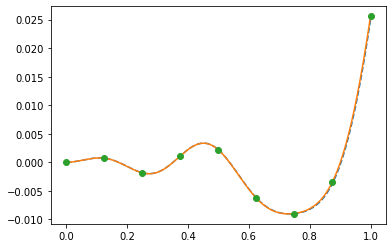

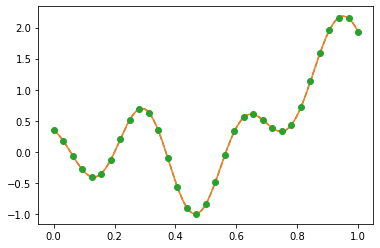

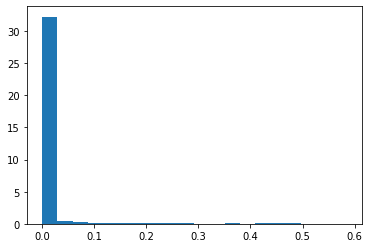

In [10]:
meta.restore()
L2 = tf.math.abs(tf.math.exp(meta.log_ks) - k_exact) / k_exact
print(np.mean(L2))

u_pred = meta.call(
    tf.constant(t, tf.float32), meta.heads,
)
f_pred = meta.pde(
    tf.constant(t, tf.float32), meta.heads, meta.log_ks,
)
plt.figure()
plt.plot(t, u_pred[:, np.argmax(L2)], '--')
plt.plot(t, u_exact[:, np.argmax(L2)])
plt.plot(t_u_train, u_train[:, np.argmax(L2)], 'o')
plt.figure()
plt.plot(t, f_pred[:, np.argmax(L2)], '--')
plt.plot(t, f[:, np.argmax(L2)])
plt.plot(t_f_train, f_train[:, np.argmax(L2)], 'o')
plt.figure()
plt.hist(L2, density=True, bins=20)
plt.show()

#### Distribution learning

In [12]:
permutation = list(np.arange(26, 52, 1)) + list(np.arange(0, 26, 1))

nf = flows.MAF(
    dim=52,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf",
)
heads = meta.heads.numpy().T
log_ks = meta.log_ks.numpy().T
data = np.concatenate([heads, log_ks], axis=-1)
# data = heads

In [13]:
t2 = time.time()
loss = nf.train_batch(tf.constant(data, tf.float32), nepoch=500)
t3 = time.time()

0 -1.246229
Elapsed:  4.202364444732666
1 -59.048187
Elapsed:  0.18493938446044922
2 -77.04337
Elapsed:  0.18428397178649902
3 -84.47442
Elapsed:  0.1867058277130127
4 -87.50337
Elapsed:  0.1812121868133545
5 -90.30657
Elapsed:  0.17322754859924316
6 -90.86577
Elapsed:  0.1957082748413086
7 -92.539856
Elapsed:  0.18067121505737305
8 -93.11021
Elapsed:  0.16758084297180176
9 -94.80591
Elapsed:  0.18415570259094238
10 -94.91817
Elapsed:  0.17617344856262207
11 -96.41327
Elapsed:  0.1828763484954834
12 -95.461075
Elapsed:  0.1302964687347412
13 -97.97125
Elapsed:  0.18305087089538574
14 -98.44719
Elapsed:  0.18022394180297852
15 -99.179405
Elapsed:  0.1640760898590088
16 -99.86877
Elapsed:  0.18220090866088867
17 -99.57159
Elapsed:  0.10477304458618164
18 -99.62014
Elapsed:  0.11894392967224121
19 -99.09936
Elapsed:  0.11060404777526855
20 -101.648735
Elapsed:  0.18636465072631836
21 -100.830185
Elapsed:  0.1067805290222168
22 -101.07394
Elapsed:  0.11884045600891113
23 -102.084435
Elapse

187 -117.14879
Elapsed:  0.1386702060699463
188 -118.69603
Elapsed:  0.13379597663879395
189 -120.20698
Elapsed:  0.19031667709350586
190 -119.98205
Elapsed:  0.13313770294189453
191 -120.57387
Elapsed:  0.19123291969299316
192 -119.18331
Elapsed:  0.1187906265258789
193 -120.4847
Elapsed:  0.10466361045837402
194 -119.601135
Elapsed:  0.1360797882080078
195 -119.721695
Elapsed:  0.13256239891052246
196 -118.09666
Elapsed:  0.1186678409576416
197 -117.90666
Elapsed:  0.129011869430542
198 -116.847694
Elapsed:  0.11999940872192383
199 -120.4602
Elapsed:  0.12639188766479492
200 -119.10286
Elapsed:  0.12887978553771973
201 -119.0918
Elapsed:  0.12837839126586914
202 -118.756294
Elapsed:  0.11171531677246094
203 -119.88599
Elapsed:  0.11396360397338867
204 -120.07683
Elapsed:  0.10997867584228516
205 -120.302444
Elapsed:  0.11233878135681152
206 -119.50605
Elapsed:  0.11095499992370605
207 -120.934875
Elapsed:  0.15642881393432617
208 -120.25561
Elapsed:  0.12226510047912598
209 -117.2552

370 -124.566505
Elapsed:  0.12799930572509766
371 -126.978294
Elapsed:  0.18500328063964844
372 -123.148674
Elapsed:  0.12299776077270508
373 -127.28247
Elapsed:  0.18400073051452637
374 -127.66472
Elapsed:  0.18799924850463867
375 -126.63353
Elapsed:  0.11400079727172852
376 -121.85254
Elapsed:  0.1159980297088623
377 -125.979034
Elapsed:  0.11600089073181152
378 -126.17918
Elapsed:  0.12099957466125488
379 -126.30649
Elapsed:  0.13100004196166992
380 -124.73911
Elapsed:  0.11600089073181152
381 -126.60036
Elapsed:  0.11899948120117188
382 -124.94773
Elapsed:  0.11299967765808105
383 -124.96439
Elapsed:  0.1080009937286377
384 -127.64997
Elapsed:  0.11100244522094727
385 -125.91717
Elapsed:  0.10899734497070312
386 -127.23508
Elapsed:  0.1100003719329834
387 -126.6434
Elapsed:  0.10899972915649414
388 -124.469215
Elapsed:  0.10900068283081055
389 -127.52103
Elapsed:  0.10899925231933594
390 -123.54814
Elapsed:  0.10900092124938965
391 -125.56737
Elapsed:  0.10799908638000488
392 -126.

(-1.0, 1.0)

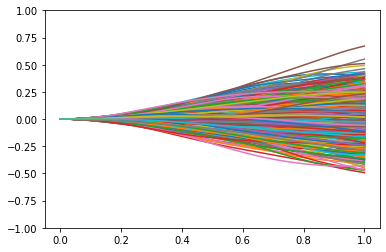

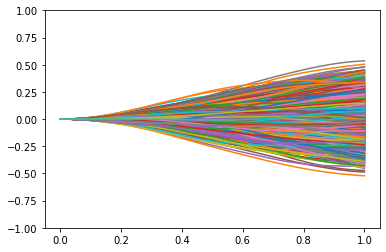

In [14]:
nf.restore()
samples = nf.sample(10000)
heads = samples[:, 0:-1]
log_ks = samples[:, -1:]

t_test = tf.constant(np.linspace(0, 1, 257).reshape([-1, 1]), tf.float32)

u_pred = meta.call(t_test, tf.transpose(heads))
for i in range(1000):
    plt.plot(t_test, u_pred[:, i])
plt.ylim([-1.0, 1])
    
plt.figure()
for i in range(1000):
    plt.plot(t_test, u_ref[:, 0, i])
plt.ylim([-1.0, 1])

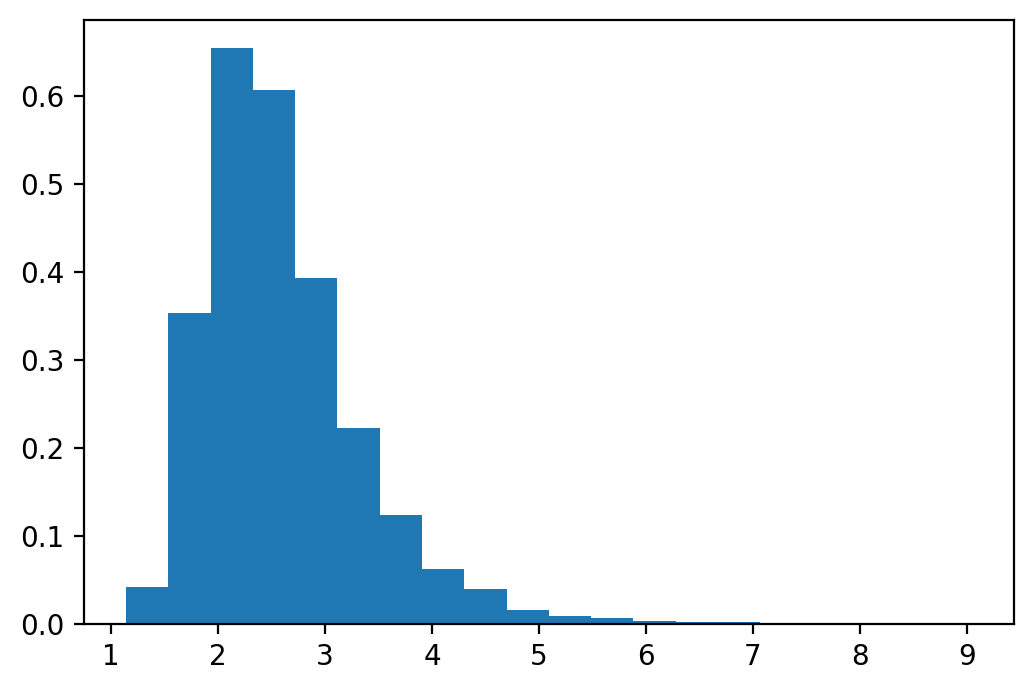

In [15]:
plt.figure(dpi=200)
plt.hist(tf.math.exp(log_ks).numpy().flatten(), density=True, bins=20)
# plt.hist(tf.math.exp(meta.log_ks), density=True, bins=20, alpha=0.3)
plt.savefig("histogram.png")
plt.show()

(-4.0, 4.0)

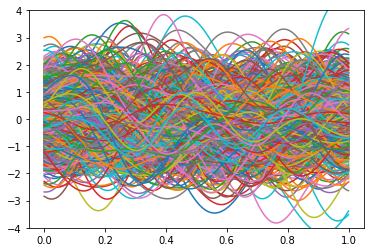

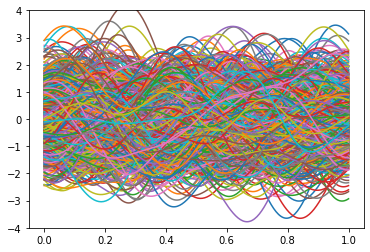

In [41]:
f_pred = meta.pde(t_test, tf.transpose(heads), tf.transpose(log_ks))
for i in range(1000):
    plt.plot(t_test, f_pred[:, i])
plt.ylim([-4.0, 4])

plt.figure()
for i in range(1000):
    plt.plot(t_test, f[:, i])
plt.ylim([-4.0, 4])

In [43]:
# save results
sio.savemat(
    "samples.mat",
    {
        "t": t_test.numpy(),
        "learned": f_pred.numpy()[:, :1000],
        "trained": f[:, :1000]
    }
)

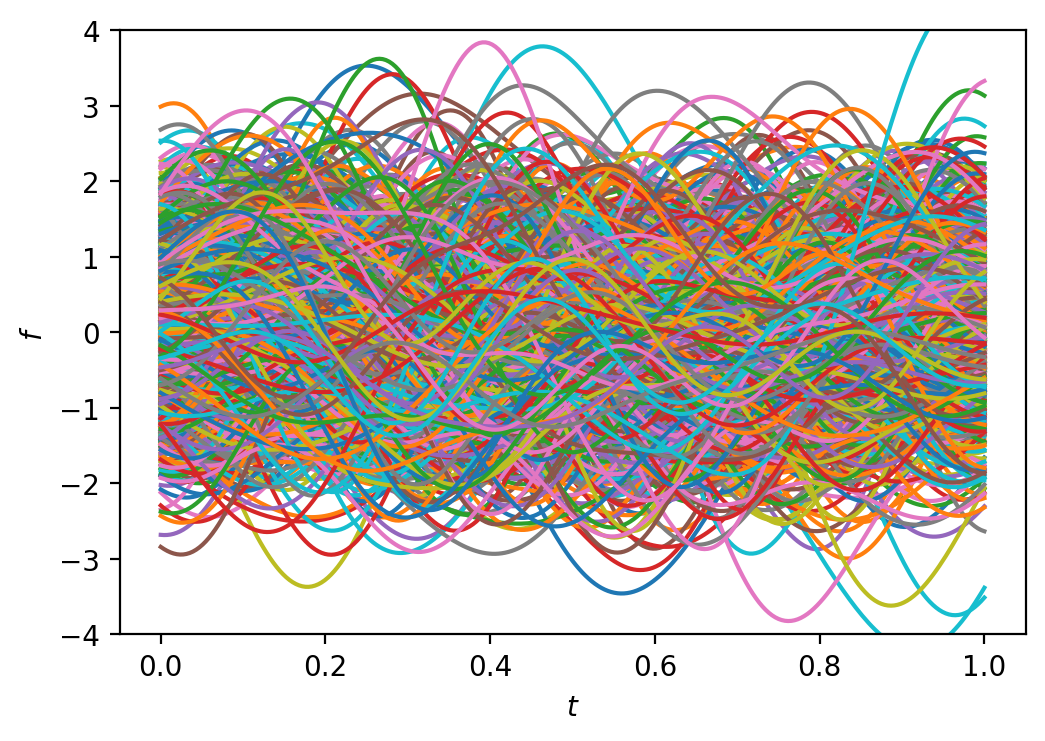

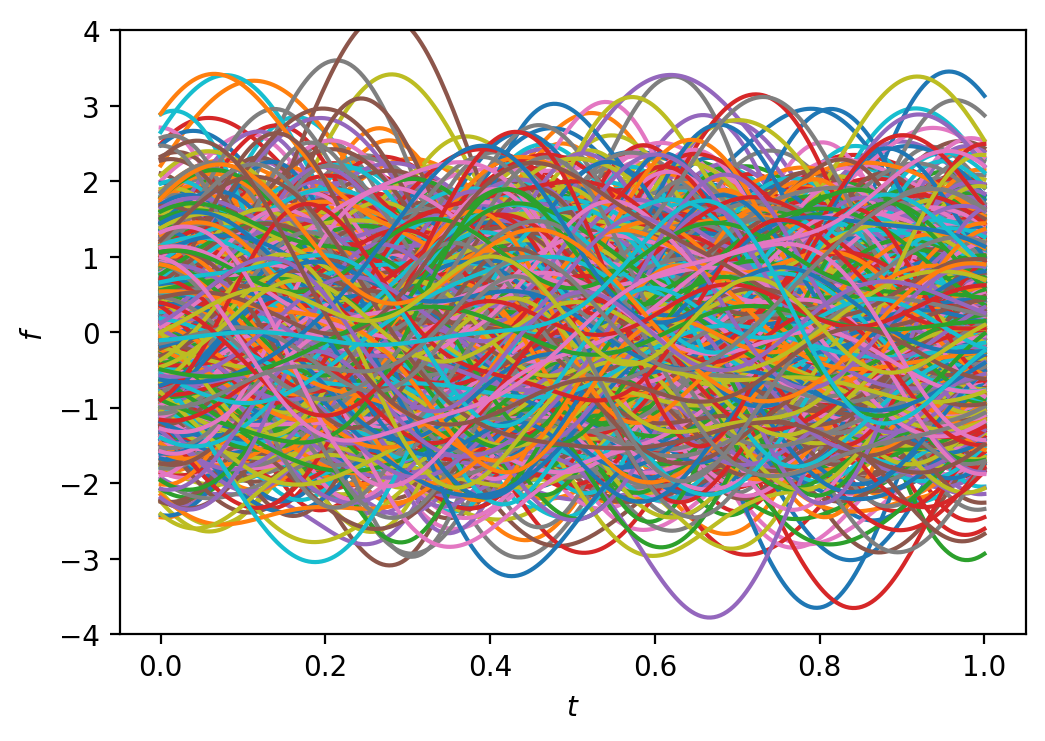

In [17]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
for i in range(1000):
    ax.plot(t_test, f_pred[:, i])
ax.set_box_aspect(2/3)
ax.set_ylim([-4, 4])
ax.set_ylabel("$f$")
ax.set_xlabel("$t$")
fig.savefig("samples_learned_distribution.png")

fig = plt.figure(dpi=200)
ax = fig.add_subplot()
for i in range(1000):
    ax.plot(t_test, f[:, i])
ax.set_box_aspect(2/3)
ax.set_ylim([-4, 4])
ax.set_ylabel("$f$")
ax.set_xlabel("$t$")
fig.savefig("samples_trained_distribution.png")

In [18]:
import tensorflow_probability as tfp

K = tfp.stats.covariance(tf.transpose(f_pred)).numpy() / 256
print(K.shape)
eigs = np.real(np.linalg.eigvals(K)).astype(np.float32)
eigs = eigs[np.argsort(-eigs)]

K = tfp.stats.covariance(tf.transpose(f)).numpy() / 256
print(K.shape)
eigs2 = np.real(np.linalg.eigvals(K)).astype(np.float32)
eigs2 = eigs2[np.argsort(-eigs2)]

(257, 257)
(257, 257)


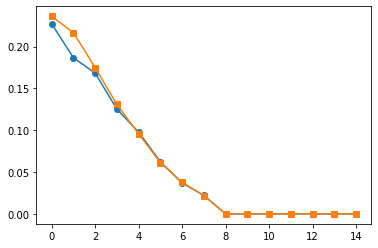

In [19]:
plt.plot(eigs[:15], '-o')
plt.plot(eigs2[:15], '-s')

In [20]:
samples.shape

TensorShape([10000, 52])

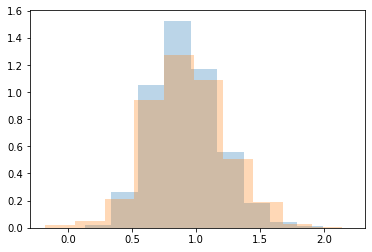

In [21]:
plt.hist(samples[:, -1], density=True, alpha=0.3)
plt.hist(meta.log_ks.numpy().flatten(), density=True, alpha=0.3)
plt.show()

In [22]:
a = [1, 2, 3, 4]

In [ ]:
a[-1:]